<a href="https://colab.research.google.com/github/Eligoze75/Whatsapp-group-analysis/blob/master/Whatsapp_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emojis plotly --upgrade

     |████████████████████████████████| 12.9MB 320kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


### Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex
import re
import io
import plotly.express as px
import plotly.graph_objects as go
import emojis
from wordcloud import WordCloud
from collections import Counter
import json
#Colabs
from google.colab import files


In [ ]:
uploads = files.upload()

Saving chat.txt to chat.txt
Saving stopwords.json to stopwords.json


In [ ]:
chat = pd.read_csv('chat.txt', sep = '\|', header=None, engine = 'python')
#chat = pd.read_csv(io.BytesIO(uploads['chat.txt']), sep = '\|', header=None, engine = 'python')

## Cleansing 🧐

Spliting text into columns:


In [ ]:
#Splitting datetime and rest 
datetime_text = chat[0].str.split("]", n = 1, expand = True) 
chat[['Date_time','Text']] = datetime_text

#Splitting date and time
Date_time = chat['Date_time'].str.split(" ", n = 1, expand = True) 
chat[['Date','Time']] = Date_time

#Splitting users and messages
mess_user = chat['Text'].str.split(":", n = 1, expand = True) 
chat[['User','Message']] = mess_user

### Removing special characters

In [ ]:
#removing trash columns and special characters
chat.drop(columns = [0,'Date_time','Text'],inplace = True)
chat.Date.replace('\[','',regex= True, inplace = True)
chat.Date.replace('\/','-',regex= True, inplace = True)
chat.Date.replace('\u200e','',inplace = True, regex = True)
chat.Message.replace('\u200e','',regex = True, inplace = True)

In [ ]:
#Removing blank spaces
chat.Date = chat.Date.str.strip()
chat.Time = chat.Time.str.strip()
chat.User = chat.User.str.strip()
chat.Message = chat.Message.str.strip()
chat.User = chat.User.astype(str)

### Removing users without name and removing no user messages (messages produced by changes in the chat)  

In [ ]:
#Getting unique users
list_users = list(chat.User.unique())
#If a user contains one of the words in the following list, is not a real user
not_users_key = ['changed','created','added','left','removed','La Familia del Horror 👻']
not_users = [v for v in list_users if any(w in v for w in not_users_key)]
chat.User.replace(not_users,np.NaN,regex = True, inplace = True)
#Removing users with no name asigned
chat.User.replace('[0-9]',np.NaN,inplace = True, regex = True)
chat.dropna(inplace=True)
chat.reset_index(inplace = True, drop = True)

In [ ]:
chat.head()

,Date,Time,User,Message
0,21-11-18,10:03:09,Elí González,Estaba viendo que en interjet el viaje sale en...
1,21-11-18,10:04:26,Machorro,Y planeas moverte en Taxi estando allá?
2,21-11-18,10:04:51,Machorro,Aparte estaríamos como a 40 min de Sayulita qu...
3,21-11-18,10:05:30,Elí González,Lo digo porque ayer estábamos hablando de los ...
4,21-11-18,10:06:00,Machorro,Yo no estaba ayer 🙄


## Fun moment! 👨🏽‍💻: Analysis! 

### Amount of messages by user 🗣

In [ ]:
#Creating dataframe from users frequency (each user entry, is a message)
aux = pd.DataFrame(chat.User.value_counts())
aux.reset_index(inplace = True)
aux.rename(columns = {'index':'User','User':'Count'},inplace=True)

In [ ]:
#colors = ['mediumpurple','lightsteelblue','cadetblue','coral','darksalmon','thistle','teal','indianred','dodgerblue']
#Creating bar plot    
fig = px.bar(aux, y=aux.User, x=aux.Count, text=aux.Count,
             color_discrete_sequence = ['coral'])

fig.update_traces(texttemplate='%{text:.2s}',
                        textposition='outside')

fig.update_layout(title_text = 'Amount of messages by user',
                    #uniformtext_minsize=8,
                    title_x = 0.5)
fig.show()

### Amount of messages over time 🗓

In [ ]:
#Giving datetime format to date column
chat['Date'] = pd.to_datetime(chat['Date'], format='%d-%m-%y')
#Creating new dataframe by grouping by date
over_date = chat.groupby(by = 'Date', as_index = False).agg({'Message':'count'}).sort_values(by = 'Date', ascending= False)
over_date.columns = ['Date','Messages_count']
over_date.head()

,Date,Messages_count
243,2020-08-15,17
242,2020-08-13,12
241,2020-08-12,7
240,2020-08-11,56
239,2020-08-10,4


In [ ]:
#Line plot
fig = px.line(x=over_date.Date, y=over_date.Messages_count, labels={'x':'Date', 'y':'Amount of messages'})

fig.update_layout(title_text = 'Amount of messages over time',
                    uniformtext_minsize=8,
                    title_x = 0.5,
                    uniformtext_mode='hide')
fig.show()

### ¿Qué días salimos a tomar con más frequencia? 🍺

In [ ]:
#Primero pasamos a días de la semana (usa la fechaaa)
#lista de palabras que impliquen tomar (sencillo) / Usamos paqueterías de NLP para identificar las palabras más usadas (en viernes y sábado)
#Fuzzywuzzy similitud de palabras / frases
#Hacer conteo de cuántas veces aparecen estas palabras por día
#Hacemos comparación por día de la semana (group by)
#graficamos y listo

In [ ]:
#Creating weekday column from date
chat['Day']= chat['Date'].apply(lambda t: t.strftime('%A'))

In [ ]:
#chat.Message.loc[chat.wkday == 'Friday'].value_counts()[:40]

In [ ]:
chat.head()

,Date,Time,User,Message,Day
0,2018-11-21,10:03:09,Elí González,Estaba viendo que en interjet el viaje sale en...,Wednesday
1,2018-11-21,10:04:26,Machorro,Y planeas moverte en Taxi estando allá?,Wednesday
2,2018-11-21,10:04:51,Machorro,Aparte estaríamos como a 40 min de Sayulita qu...,Wednesday
3,2018-11-21,10:05:30,Elí González,Lo digo porque ayer estábamos hablando de los ...,Wednesday
4,2018-11-21,10:06:00,Machorro,Yo no estaba ayer 🙄,Wednesday


### Amount of words by user and weekday 😟

In [ ]:
#Getting words by splitting each message
chat['word_count'] = chat['Message'].apply(lambda x: len(x.split(' ')))

In [ ]:
chat.head()

,Date,Time,User,Message,Day,word_count
0,2018-11-21,10:03:09,Elí González,Estaba viendo que en interjet el viaje sale en...,Wednesday,28
1,2018-11-21,10:04:26,Machorro,Y planeas moverte en Taxi estando allá?,Wednesday,7
2,2018-11-21,10:04:51,Machorro,Aparte estaríamos como a 40 min de Sayulita qu...,Wednesday,13
3,2018-11-21,10:05:30,Elí González,Lo digo porque ayer estábamos hablando de los ...,Wednesday,10
4,2018-11-21,10:06:00,Machorro,Yo no estaba ayer 🙄,Wednesday,5


In [ ]:
#Grouping by weekday and user
words_user_wk = chat.groupby(['Day','User'], as_index=False).agg({'word_count':'sum'})
words_user_wk.columns = ['Day','User','total_words']
words_user_wk.sort_values(by='Day',ascending=False, inplace = True)
words_user_wk.head()

,Day,User,total_words
125,Wednesday,Vega,496
115,Wednesday,Julio,1250
106,Wednesday,Alfredo,261
107,Wednesday,Amandurrichis,30
108,Wednesday,Apto,922


In [ ]:
#Heatmap
fig = go.Figure(data = go.Heatmap(
                x=words_user_wk["User"],
                y=words_user_wk["Day"],
                z=words_user_wk["total_words"])
               )
fig.update_xaxes(side="top")
fig.update_layout(title_text = 'Amount of words sended by user by weekday',
                    #uniformtext_minsize=8,
                    title_x = 0.5)
fig.show()

In [ ]:
words_user = chat.groupby(['User'], as_index=False).agg({'word_count':'sum'})
words_user.columns = ['User','total_words']
words_user.sort_values(by='total_words',ascending=False, inplace = True)

#Barplot    
fig = px.bar(words_user, y='total_words', x='User', text='total_words',
             color_discrete_sequence = ['lightsteelblue'])

fig.update_traces(texttemplate='%{text:.2s}',
                        textposition='outside')

fig.update_layout(title_text = 'Amount of words sent by user',
                    #uniformtext_minsize=8,
                    title_x = 0.5)
fig.show()

Most used emoji 🙌🏽

In [ ]:
#Getting unique emojis in a messajge
chat['emojis'] = chat.Message.apply(lambda x: emojis.get(x))

In [ ]:
chat.head()

,Date,Time,User,Message,Day,word_count,emojis
0,2018-11-21,10:03:09,Elí González,Estaba viendo que en interjet el viaje sale en...,Wednesday,28,{}
1,2018-11-21,10:04:26,Machorro,Y planeas moverte en Taxi estando allá?,Wednesday,7,{}
2,2018-11-21,10:04:51,Machorro,Aparte estaríamos como a 40 min de Sayulita qu...,Wednesday,13,{}
3,2018-11-21,10:05:30,Elí González,Lo digo porque ayer estábamos hablando de los ...,Wednesday,10,{😒}
4,2018-11-21,10:06:00,Machorro,Yo no estaba ayer 🙄,Wednesday,5,{🙄}


In [ ]:
#Getting a list of unique emojis from each message
emojis_list =[] 

for _ in range(0, chat.shape[0]):
  emojis_list = emojis_list + list(chat['emojis'][_])

emojis_list = list(set(emojis_list))
print('We have', len(emojis_list),'unique emojis in total')

We have 154 unique emojis in total


In [ ]:
#Funtion to find all emojis and store them into a list
def get_emojis(text):
  emj_list = []
  data = regex.findall(r'\X',text)
  for v in data:
    if v in emojis_list:
      emj_list.append(v)
  return emj_list

In [ ]:
#Applying funtion to get every emoji from each message
chat['all_emojis_in'] = chat['Message'].apply(get_emojis)

In [ ]:
chat.head()

,Date,Time,User,Message,Day,word_count,emojis,all_emojis_in
0,2018-11-21,10:03:09,Elí González,Estaba viendo que en interjet el viaje sale en...,Wednesday,28,{},[]
1,2018-11-21,10:04:26,Machorro,Y planeas moverte en Taxi estando allá?,Wednesday,7,{},[]
2,2018-11-21,10:04:51,Machorro,Aparte estaríamos como a 40 min de Sayulita qu...,Wednesday,13,{},[]
3,2018-11-21,10:05:30,Elí González,Lo digo porque ayer estábamos hablando de los ...,Wednesday,10,{😒},[😒]
4,2018-11-21,10:06:00,Machorro,Yo no estaba ayer 🙄,Wednesday,5,{🙄},[🙄]


In [ ]:
#Counting how many emojis where used by messsage
chat['emojis_inmessage_count'] = chat.Message.apply(lambda x: emojis.count(x))

In [ ]:
#Getting a list with every emoji no matter if it repeats itself (we want to count the usage of each one)
all_emj_used = []
for v in range(0,chat.shape[0]):
  all_emj_used = all_emj_used + chat['all_emojis_in'][v]

#Creating dictionary and frequency using counters
emoji_dict = dict(Counter(all_emj_used))
#Sorting and storing
emoji_dict = sorted(emoji_dict.items(), key = lambda x: x[1], reverse = True)

In [ ]:
#Creating dataframe to store data
emoji_stats = pd.DataFrame(emoji_dict,columns = ['Emoji','Count'])
emoji_stats.sort_values(by = 'Count', inplace = True, ascending = False)
emoji_stats.head()

,Emoji,Count
0,😂,431
1,🤔,85
2,🤣,65
3,🥺,44
4,😱,42


In [ ]:
#Pie chart
fig = px.pie(emoji_stats, values='Count', names='Emoji')
fig.update_traces(textposition='inside',
                  textinfo='percent+label')

fig.update_layout(title_text = 'Emojis share',
                    #uniformtext_minsize=8,
                    title_x = 0.5)
fig.show()

Who talks more? women or men? 👱🏼‍♂️👱🏼‍♀  
We already know the answer just by seeing previous sections but, still could be nice to have this in a chart.

In [ ]:
#Tagging gender to users
gender_dict = {'Elí González':'Man',
 'Machorro':'Man',
 'Julio':'Man',
 'Vega':'Woman',
 'Saulito':'Man',
 'Charlie':'Man',
  'Kath':'Woman',
  'Valdi':'Man',
  'Mitch':'Woman',
  'Gayvid':'Man',
  'Ezra':'Man',
  'Alfredo':'Man',
  'Fernando Blas':'Man',
  'Rafa':'Man',
  'Lorena Pineda':'Woman',
  'Amandurrichis':'Woman',
  'Apto':'Man',
  'Paula':'Woman',
  'Luis Mistic':'Man',
  'Champ':'Woman'}

In [ ]:
#Creating gender column
chat['Gender'] = chat['User']
chat = chat.replace({'Gender': gender_dict})

In [ ]:
#Grouping by gender
genders = chat.groupby('Gender', as_index = False).agg({'Message':'count'})
genders.rename(columns = {'Gender':'Gender','Message':'count'}, inplace = True)

#Plot
fig = px.bar(genders, y='count', x='Gender', text='count',
             color_discrete_sequence = ['thistle'])

fig.update_traces(texttemplate='%{text:.2s}',
                        textposition='outside')

fig.update_layout(title_text = 'Amount of messages by gender',
                    #uniformtext_minsize=8,
                    title_x = 0.5)
fig.show()

### Most used words and most talked about topic 📲

In [ ]:
media = ['sticker','this','message','omitted','image','audio','video','deleted','was']
names = ['apto','kath','fer','carlos','rafa','machorro','champ','mistic','amanda',
         'mitch','mish','julio','ezra','eli','vega','lore','vladi','vlackout','saul',
         'rony','charly','luis','pau','astrid'] 
words = ' '.join(chat.Message)
words = words.split()
cleaned_words = [v for v in words if v.lower() not in media and v.lower() not in names]
clean_messages = ' '.join(cleaned_words)


In [ ]:
#stopwords = json.loads(uploads['stopwords.json'])
stopwords = pd.read_json('stopwords.json')
stopwords = list(stopwords['words'])
stopwords = stopwords + ['jaja','jajaja','jajajaja','ah','allá','tu','te','ay','deja','vas','ok']
stopwords

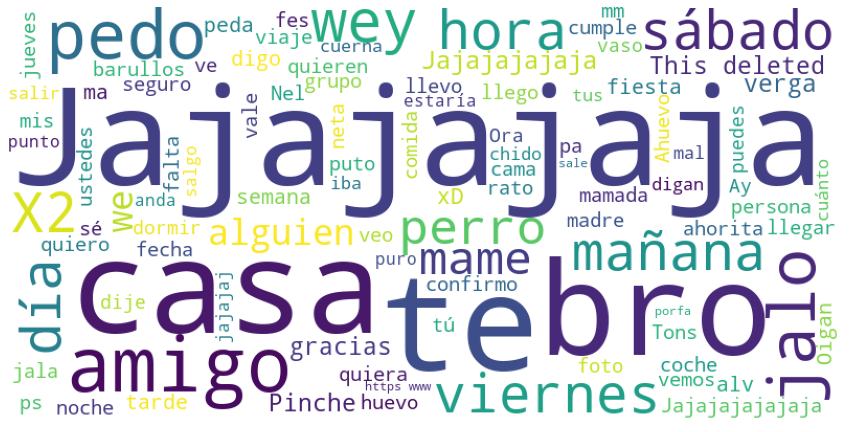

In [ ]:
wordcloud = WordCloud(width = 800,
                      height = 400,
                      max_words = 100,
                      background_color='white',
                      #stopwords = stopwords['words']
                      stopwords = stopwords).generate(text = clean_messages)

plt.figure(figsize = (15,10))
plt.imshow(wordcloud)
plt.axis('off')

plt.show()

# Brainstorm
* ¿Qué días de la semana hablamos más? - Elí ✔️
* ¿Qué días salimos a tomar con más frequencia? - Kathii
* ¿Cuántas palabras ha mandado cada usuario? - Elí ✔️
* ¿Cuál es el emoji más usado? - Elí ✔️ (Es el 😂)
* ¿Cuál es el tema más hablado?
* ¿Cuáles son las 5 palabras más usadas?
* ¿Análisis de sentimientos? 
* ¿Quién habla más Hombres o mujeres? - Elí ✔️